In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

### style 별로 이미지 선별했기 때문에 따로 불러와서 분류 작업 불필요

## style 분류 모델 생성

In [14]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(150,150, 3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
 
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
 
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))
 
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))                                   # label, calss 갯수
model.summary()
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 16)      432       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 16)      48        
_________________________________________________________________
activation_5 (Activation)    (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 38, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 38, 32)        4608      
_________________________________________________________________
batch_normalization_6 (Batch (None, 38, 38, 32)        96        
__________

In [15]:
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


# 데이터 셋
train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=10,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.7,
#                                    zoom_range=[0.9, 2.2],
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    fill_mode='nearest',
                                   validation_split=0.33)
 
training_set = train_datagen.flow_from_directory('C:/python_DA/img/crawling_img',
                                                 target_size = (150,150),
                                                 batch_size = 10,
                                                 class_mode = 'categorical',
                                                 subset="training"
                                                )
validation_set = train_datagen.flow_from_directory('C:/python_DA/img/crawling_img',
                                                 target_size = (150,150),
                                                 batch_size = 10,
                                                 class_mode = 'categorical',
                                                 subset="validation"
                                                  )
 

Found 1977 images belonging to 3 classes.
Found 972 images belonging to 3 classes.


### 옵션 적용해서 학습

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


# moniter: 대상 값, mode: min/max, verbose=1 설정시 언제 멈췄는지 출력
# patience: 성능없는 에폭 허용 범위, baseline: 값 설정

#es = EarlyStopping(monitor='val_loss', mode='min')
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)



In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model_style.h5', monitor='val_loss', mode='min', save_best_only=True)

In [18]:
hist = model.fit_generator(training_set,
                         steps_per_epoch = 20, #20
                         epochs = 50,  #1000
                         validation_data = validation_set,
                         validation_steps = 10,
                         callbacks=[es,mc])
 

Epoch 1/50
20/20 [==============================] - 17s 872ms/step - loss: 1.7034 - acc: 0.4350 - val_loss: 1.0508 - val_acc: 0.3800
Epoch 2/50
20/20 [==============================] - 17s 825ms/step - loss: 1.0333 - acc: 0.4800 - val_loss: 1.1801 - val_acc: 0.3100
Epoch 3/50
20/20 [==============================] - 17s 869ms/step - loss: 1.0133 - acc: 0.5350 - val_loss: 0.9685 - val_acc: 0.6000
Epoch 4/50
20/20 [==============================] - 17s 852ms/step - loss: 1.0103 - acc: 0.5450 - val_loss: 0.9991 - val_acc: 0.5400
Epoch 5/50
20/20 [==============================] - 17s 868ms/step - loss: 0.9715 - acc: 0.5550 - val_loss: 0.9068 - val_acc: 0.6000
Epoch 6/50
20/20 [==============================] - 17s 844ms/step - loss: 1.0124 - acc: 0.4600 - val_loss: 0.9051 - val_acc: 0.6000
Epoch 7/50
20/20 [==============================] - 17s 845ms/step - loss: 0.9677 - acc: 0.5200 - val_loss: 0.9090 - val_acc: 0.5800
Epoch 8/50
20/20 [==============================] - 16s 821ms/step - 

In [19]:

# 모델 평가하기
print("-- Evaluate --")
 
scores = model.evaluate_generator(
            validation_set,
            steps = 10)
 
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
 
# 모델 예측하기
print("-- Predict --")
 
output = model.predict_generator(
            validation_set,
            steps = 100)
print(validation_set.class_indices)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
 

-- Evaluate --
acc: 58.00%
-- Predict --
{'casual': 0, 'feminine': 1, 'formal': 2}


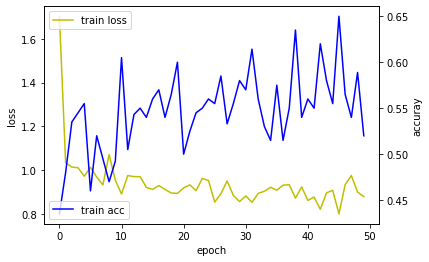

In [20]:
import matplotlib.pyplot as plt
 
fig, loss_ax = plt.subplots()
 
acc_ax = loss_ax.twinx()
 
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
#loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
##loss_ax.set_ylim([0.0, 0.5])
 
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
##acc_ax.set_ylim([0.8, 1.0])
 
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
 
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
 
plt.show()

In [21]:
# 모델 저장
from keras.models import load_model, model_from_json
model.save('model_style_3종류.h5')                       # 모델(architecture, weight 동시 저장) 저장 이름


# 모델 아키텍처를 json 형, 식으로 저장                 # 모델 architecture 만 저장 
#json_string = model.to_json()                       # json 파일에서 모델 아키텍처 재구성
#model = model_from_json(json_string) 


# 모델 Weights 저장
#model.save_weights()


In [ ]:
from keras.models import load_model
model = load_model('model_style_3종류.h5')
model = model.load_weights('model_style_3종류_w.h5')